# 데이터 전처리

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import re
import seaborn as sns
import warnings
import lightgbm as lgbm

from category_encoders import OneHotEncoder, OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline

warnings.filterwarnings(action='ignore')

#abcd efg hijk lmn opqr stu vwxyz

In [2]:
df = pd.read_csv('./data/movie_train.csv')
df.head(3)

,imdbID,Title,Year,Genre,Director,Language,Country,Poster,imdbRating,BoxOffice
0,tt0237572,The Pledge,2001,"Crime, Drama, Mystery",Sean Penn,English,"United States, Canada",https://m.media-amazon.com/images/M/MV5BNTJjNT...,6.8,"$19,733,089"
1,tt0237865,Twilight: Los Angeles,2000,Drama,Marc Levin,English,United States,https://m.media-amazon.com/images/M/MV5BMjE5Mj...,7.6,"$10,688"
2,tt0237993,101 Reykjavík,2000,"Comedy, Romance",Baltasar Kormákur,"Icelandic, English, Spanish","Iceland, Denmark, France, Norway, Germany",https://m.media-amazon.com/images/M/MV5BMTIyNT...,6.8,"$126,404"


In [3]:
target = 'BoxOffice'

In [4]:
df.shape

(4177, 10)

## 결측치 확인 및 제거

In [5]:
df.isnull().sum()

imdbID         0
Title          0
Year           0
Genre          4
Director       3
Language       7
Country        0
Poster        15
imdbRating     0
BoxOffice      0
dtype: int64

In [6]:
df.head(10)

,imdbID,Title,Year,Genre,Director,Language,Country,Poster,imdbRating,BoxOffice
0,tt0237572,The Pledge,2001,"Crime, Drama, Mystery",Sean Penn,English,"United States, Canada",https://m.media-amazon.com/images/M/MV5BNTJjNT...,6.8,"$19,733,089"
1,tt0237865,Twilight: Los Angeles,2000,Drama,Marc Levin,English,United States,https://m.media-amazon.com/images/M/MV5BMjE5Mj...,7.6,"$10,688"
2,tt0237993,101 Reykjavík,2000,"Comedy, Romance",Baltasar Kormákur,"Icelandic, English, Spanish","Iceland, Denmark, France, Norway, Germany",https://m.media-amazon.com/images/M/MV5BMTIyNT...,6.8,"$126,404"
3,tt0237994,15 février 1839,2001,"Drama, History",Pierre Falardeau,"French, English, Latin",Canada,https://m.media-amazon.com/images/M/MV5BMGI2Y2...,7.2,"$43,595"
4,tt0238015,All Access: Front Row. Backstage. Live!,2001,"Documentary, Music",Martyn Atkins,English,USA,https://m.media-amazon.com/images/M/MV5BNjU1Nz...,8.2,"$992,683"
5,tt0238066,Bounce: Behind the Velvet Rope,2000,Documentary,Steven Cantor,English,United States,https://m.media-amazon.com/images/M/MV5BMTg4ND...,6.6,"$8,779"
6,tt0238112,Captain Corelli's Mandolin,2001,"Drama, Music, Romance",John Madden,"English, Greek, German, Italian","United Kingdom, France, United States",https://m.media-amazon.com/images/M/MV5BNzc0Mm...,5.9,"$25,543,895"
7,tt0238247,God's Army,2000,Drama,Richard Dutcher,English,United States,https://m.media-amazon.com/images/M/MV5BYWIxOT...,6.4,"$2,637,726"
8,tt0238321,Ivans xtc.,2000,Drama,Bernard Rose,English,"United Kingdom, United States",https://m.media-amazon.com/images/M/MV5BNDE4MT...,6.5,"$47,027"
9,tt0238380,Equilibrium,2002,"Action, Drama, Sci-Fi",Kurt Wimmer,English,United States,https://m.media-amazon.com/images/M/MV5BMTkzMz...,7.4,"$1,203,794"


In [4]:
def preprocessing(df):
    # 결측치 제거
    df_ml = df.dropna(axis=0)
    
    # imdbID, 포스터, Title,  컬럼 드랍
    df_ml.drop(['Poster'], axis=1, inplace=True)
    df_ml.drop(['imdbID'], axis=1, inplace=True)
    df_ml.drop(['Title'], axis=1, inplace=True)
#     df_ml.drop(['Language'], axis=1, inplace=True)
#     df_ml.drop(['Country'], axis=1, inplace=True)
#     df_ml.drop(['Director'], axis=1, inplace=True)
    
    # BoxOffice 컬럼 단위 제거 및 int형으로 변경
    df_ml['BoxOffice'] = df_ml['BoxOffice'].str.replace(r"[^0-9]", r"", regex=True)
    df_ml['BoxOffice'] = df_ml['BoxOffice'].astype('int')
    
    # Genre를 하나씩 분리하기 (Genre_single 컬럼 생성) 및 Genre 컬럼 삭제
    result = df_ml['Genre'].str.replace(" ", "")
    result = result.str.split(',')
    result = result.apply(lambda x: pd.Series(x))
    result = result.stack().reset_index(level=1, drop=True).to_frame('Genre_single')
    result = result.replace(" ", "")
    df_ml = df_ml.merge(result, left_index=True, right_index=True, how='left')
    df_ml.drop(['Genre'], axis=1, inplace=True)
    
    
    # 대표 감독, 언어, 국가만 넣기
    df_ml['Director'] = df_ml['Director'].str.split(',').str.get(0)
    df_ml['Language'] = df_ml['Language'].str.split(',').str.get(0)
    df_ml['Country'] = df_ml['Country'].str.split(',').str.get(0)
    
    # usa로 통일
    df_ml['Country'] = df_ml['Country'].str.replace('United States', 'USA')
    
    return df_ml

df_ml = preprocessing(df)

In [5]:
df_ml.head(10)

,Year,Director,Language,Country,imdbRating,BoxOffice,Genre_single
0,2001,Sean Penn,English,USA,6.8,19733089,Crime
0,2001,Sean Penn,English,USA,6.8,19733089,Drama
0,2001,Sean Penn,English,USA,6.8,19733089,Mystery
1,2000,Marc Levin,English,USA,7.6,10688,Drama
2,2000,Baltasar Kormákur,Icelandic,Iceland,6.8,126404,Comedy
2,2000,Baltasar Kormákur,Icelandic,Iceland,6.8,126404,Romance
3,2001,Pierre Falardeau,French,Canada,7.2,43595,Drama
3,2001,Pierre Falardeau,French,Canada,7.2,43595,History
4,2001,Martyn Atkins,English,USA,8.2,992683,Documentary
4,2001,Martyn Atkins,English,USA,8.2,992683,Music


In [9]:
df_ml.nunique()

Year              32
Director        2907
Language          71
Country           68
imdbRating        71
BoxOffice       4118
Genre_single      23
dtype: int64

In [10]:
df_ml['Country'].unique()

array(['USA', 'Iceland', 'Canada', 'United Kingdom', 'China', 'India',
       'France', 'Portugal', 'Italy', 'Australia', 'Denmark', 'Japan',
       'Taiwan', 'Czech Republic', 'Brazil', 'Germany', 'Netherlands',
       'Mexico', 'South Korea', 'Iran', 'Poland', 'Argentina', 'Hungary',
       'New Zealand', 'Spain', 'Hong Kong', 'Belgium', 'Sweden',
       'Colombia', 'UK', 'Israel', 'Thailand', 'Norway', 'Senegal',
       'Austria', 'South Africa', 'Switzerland', 'Philippines', 'Algeria',
       'Ireland', 'Tunisia', 'Occupied Palestinian Territory', 'Russia',
       'Finland', 'Burkina Faso', 'Chile', 'Afghanistan', 'Turkey',
       'Pakistan', 'Republic of Macedonia', 'Greece', 'Cambodia',
       'Venezuela', 'Kazakhstan', 'Serbia', 'Puerto Rico', 'Romania',
       'Singapore', 'Bosnia and Herzegovina', 'Luxembourg', 'Cameroon',
       'Bhutan', 'Lebanon', 'Uruguay', 'Mali', 'Chad', 'Malaysia',
       'Vietnam'], dtype=object)

# ML 모델 구현

In [11]:
df_ml.shape

(9495, 7)

In [6]:
baseline = df_ml[target].mean()
baseline

22944110.956608742

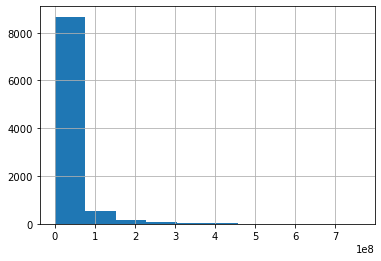

In [13]:
df_ml[target].hist()

In [14]:
features = df_ml.drop(columns=[target]).columns
features

Index(['Year', 'Director', 'Language', 'Country', 'imdbRating',
       'Genre_single'],
      dtype='object')

In [25]:
# from sklearn.model_selection import train_test_split

# # 학습과 테스트 데이터 세트를 반환하는 함수.
# def get_train_test_dataset(df):    
#     ohEncoder = OneHotEncoder()
#     df = ohEncoder.fit_transform(df)
    
#     features = df.drop(columns=[target]).columns
    
#     # 타겟값을 log1p() 변환. (정규 분포 형태로 바꾸기 위함)
#     df_target_log = np.log1p(df[target])
    
#     X_train, X_test, y_train, y_test = train_test_split(df[features], df_target_log, test_size=0.2, random_state=2)  
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)


#     # 학습과 테스트 데이터 세트 반환
#     return X_train, X_test, X_val, y_train, y_test, y_val

# X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_dataset(df_ml)





from sklearn.model_selection import train_test_split

# 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df):    
    
    features = df.drop(columns=[target]).columns
    
    # 타겟값을 log1p() 변환. (정규 분포 형태로 바꾸기 위함)
    df_target_log = np.log1p(df[target])
    
    X_train, X_test, y_train, y_test = train_test_split(df[features], df_target_log, test_size=0.2, random_state=2)  


    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(df_ml)

In [26]:
X_train.shape

(7596, 6)

In [27]:
y_train.shape

(7596,)

In [28]:
print(X_train.shape, X_test.shape)

(7596, 6) (1899, 6)


In [29]:
print(y_train.shape, y_test.shape)

(7596,) (1899,)


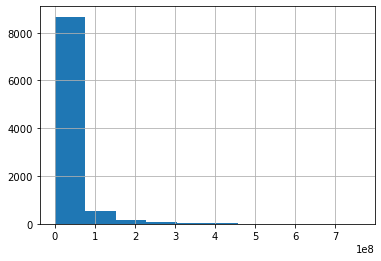

In [30]:
# log 변환 전의 skewed 모습.
df_ml[target].hist()

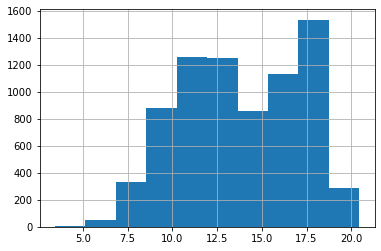

In [31]:
# 정규화 형태를 띄는 것을 볼 수 있다.
y_train.hist()

In [32]:
# MSE, MAE 계산
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_regressor(y, pred):
    mse = mean_squared_error(y, pred)
    mae = mean_absolute_error(y, pred)
    r2 = r2_score(y, pred)
    print('MSE: ', mse,  'MAE: ', mae, 'r2 : ', r2)

# 모델링 with 파이프라인

In [43]:
# 모델을 학습, 예측, 평가 하는 함수
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    
    y_test_exp = np.expm1(tgt_test)
    pred_exp = np.expm1(pred)
    
    # 예측 결과 평가 지표
    evaluate_regressor(y_test_exp, pred_exp)
    
    # 예측 결과 그래프
    modeling_result = pd.concat([y_test_exp.reset_index(drop=True), pd.DataFrame(pred_exp)], axis = 1)
    modeling_result.columns = ['label','predict']
    sns.regplot(x = 'label', y = 'predict', data = modeling_result)
    

MSE:  2457977452637700.0 MAE:  19274272.111088194 r2 :  0.1383190126138506


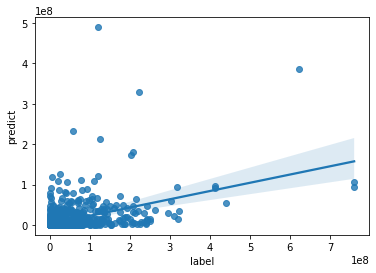

In [44]:
from lightgbm import LGBMRegressor

pipe = Pipeline([
    ('preprocessing', OneHotEncoder()),
    ('LGBM', LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=50, num_iterations=200, random_state=2))
])

get_model_train_eval(pipe, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

In [28]:
# # LGBMRegressor 튜닝할 하이퍼파라미터의 범위를 지정해 주는 부분
# dists = {
#     'LGBM__learning_rate': [0.01, 0.2],
#     'LGBM__n_estimators': [10, 1000],
#     'LGBM__learning_rate': [0, 1],
#     'LGBM__num_iterations': [0, 200, 500],
#     'LGBM__subsamples': [0, 10, 200]
# }

# random_search = RandomizedSearchCV(
#     pipe, 
#     param_distributions=dists, 
#     n_iter=50, 
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )
# random_search.fit(X_train, y_train);
# print('최적 하이퍼파라미터: ', random_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
최적 하이퍼파라미터:  {'LGBM__subsamples': 0, 'LGBM__num_iterations': 200, 'LGBM__n_estimators': 10, 'LGBM__learning_rate': 1}


In [45]:
# 유저가 예측하고자 하는 영화 케이스

def predict_boxoffice(model, Year, Director, Language, Country, imdbRating, Genre_single ):
    df = pd.DataFrame(
        data=[[Year, Director, Language, Country, imdbRating, Genre_single]], 
        columns=['Year', 'Director', 'Language', 'Country', 'imdbRating', 'Genre_single']
    )

    # 예측
    pred = np.expm1(model.predict(df)[0])
    
    return pred

    
predicted_value = predict_boxoffice(pipe, 2020, 'Wes Anderson', 'English', 'USA', 8.5, 'Romance')
predicted_value

6154325.593781005

In [46]:
# 모델 피클링
with open('pipe.pkl','wb') as pickle_file:
    pickle.dump(pipe, pickle_file)

In [47]:
# 모델 load 및 예상 boxoffice 출력
model = None
with open('pipe.pkl','rb') as pickle_file:
   model = pickle.load(pickle_file)

In [49]:
predict_boxoffice = predict_boxoffice(model, 2020, 'Wes Anderson', 'English', 'USA', 8.5, 'Romance')
print(f'예상 boxoffice은 ${int(predict_boxoffice)} 입니다.')

예상 boxoffice은 $6154325 입니다.
